# **基於Twitter評論分析近期OpenAI與ChatGpt的討論趨勢**



*   組別:Group 4
*   組員:M134020044 李晉豪 M134020030 戴廣琛 M134610017 李逸華 M134020036 謝昕叡
*   youtube 影片連結:https://www.youtube.com/watch?v=a-f9jf7gMoQ



## 專案動機
自從 ChatGPT 問世以來，生成式 AI 正式進入大眾日常生活，並快速推動整體產業進入轉型浪潮。與 AI 相關的應用如雨後春筍般湧現，企業也積極尋求將 AI 技術導入至產品與營運中，形成一股跨產業的創新趨勢。

其中，OpenAI 作為目前最受矚目的 AI 公司，其推出的 ChatGPT 不僅擁有龐大用戶數，也頻繁成為社群媒體與科技新聞的討論焦點。因此，本專案希望透過分析社群媒體上對於 OpenAI 與 ChatGPT 的實際回饋，觀察當前生成式 AI 的發展趨勢與熱門議題。

我們關注使用者在社群網路中表現出對OpenAI與ChatGpt的滿意與不滿之處，藉此找出具代表性的應用亮點、潛在爭議與信任痛點，進一步整理成對企業導入 AI 的啟示與建議，以協助有意導入 AI 的組織掌握趨勢並創造價值。

## 大綱
1. 資料前處理
2. W2V<br>
  2.1 W2V模型設定<br>
  2.2 2D圖<br>
  2.3 3D圖<br>
3. 主題模型<br>
  3.1 LDA<br>
  3.2 BertTopic<br>
4. LLM主題推論<br>
5. 官方文件RAG<br>
6. 情緒分析<br>
7. 結論<br>


### 1. 資料前處理

安裝與導入套件

In [ ]:
 !pip install  nbformat>=4.2.0
 !pip install gensim
 !pip install pyLDAvis
 !pip install bertopic

 # 安裝 LangChain 的主套件
!pip install langchain langchain-core langchain-community langchain-text-splitters langchain-chroma

# 安裝 Ollama 支援（用於本地模型）
!pip install langchain-ollama ollama

# 安裝 SentenceTransformer 用於向量嵌入
!pip install sentence-transformers

# 安裝 Chroma 向量資料庫
!pip install chromadb

# 若需要處理 PDF
!pip install pypdf

# 若使用 HuggingFace Endpoint
!pip install huggingface_hub
# 安裝完重新起動執行階段

  Using cached bertopic-0.17.0-py3-none-any.whl.metadata (23 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manyl

^C


In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from pprint import pprint
import time

import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.matutils import corpus2csc
import multiprocessing

import pyLDAvis
import pyLDAvis.gensim_models

import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
from matplotlib.font_manager import fontManager
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import os
from getpass import getpass

import pandas as pd
import ast
import json
import re
import jieba

import torch


import ollama
from langchain_community.llms import HuggingFaceEndpoint

from langchain_ollama.llms import OllamaLLM

from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables import RunnableLambda

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

/usr/local/lib/python3.11/dist-packages/hdbscan/plots.py:448: DeprecationWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.11/dist-packages/hdbscan/robust_single_linkage_.py:154: DeprecationWarning: invalid escape sequence '\{'
  """Perform robust single linkage clustering from a vector array
/usr/local/lib/python3.11/dist-packages/geopandas/_compat.py:7: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos
/usr/local/lib/python3.11/dist-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.11/dist-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg

ModuleNotFoundError: No module named 'ollama'

In [2]:
#李晉豪雲端導向
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir('/content/drive/MyDrive/Colab Notebooks/SMA_finalProject/final_sma') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['raw_data', '.ipynb_checkpoints']

導入從X上爬下來的評論，爬取規則如下:<br>
1. 關鍵字為openai與chatgpt
2. 篩選Top與Latest的評論抓取資料
3. 因為X反爬蟲的關係，按照上述規則重複爬取20次<br>

將所有評論合併後去除重複值

In [ ]:
x1 = pd.read_csv("raw_data/tweets_text_time.csv")
x2 = pd.read_csv("raw_data/gpt.csv")
x3 = pd.read_csv("raw_data/gpt+openai.csv")
x4 = pd.read_csv("raw_data/g3.csv")

x = pd.concat([x1, x2, x3, x4], ignore_index=True)

x = x.drop_duplicates().reset_index()

x




,index,Time,Content
0,0,2025-06-01T14:13:27.000Z,USA : OpenAI is leading the future.\nChina ...
1,1,2025-06-10T02:14:19.000Z,Here's another way ChatGPT is being used to fu...
2,2,2025-06-08T16:53:08.000Z,It's been 24 hours since the OpenAI changed ...
3,3,2025-06-10T02:10:51.000Z,JUST IN: OpenAI drops the price of o3 by 80%...
4,4,2025-06-09T18:06:12.000Z,OpenAI hits $10B ARR just 2.5 years after the...
...,...,...,...
2578,2690,2025-06-10T07:37:19.000Z,OpenAI pushed an update to ChatGPT 's Advanc...
2579,2691,2025-06-10T07:52:16.000Z,Just in time for Apple's #WWDC @OpenAI ann...
2580,2692,2025-06-10T07:49:44.000Z,During his 4 years as an engineer at OpenAI ...
2581,2693,2025-06-10T07:55:10.000Z,It would be very funny if @OpenAI would allo...


In [ ]:
nltk.download('stopwords')
# 清理資料
x['sentence'] = x['Content'].str.lower()

x['sentence'] = x['sentence'].str.replace(r'\n\n','.', regex=True)# 換成一個句點 .
x['sentence'] = x['sentence'].str.replace(r'\n','', regex=True)
x['sentence'] = x['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
x['sentence'] = x['sentence'].str.replace(r'[^A-Za-z\s]', '', regex=True)

# 停用字清單
stop_words = stopwords.words('english')
custom_stopwords = [
    'chatgpt', 'openai', 'new', 'us', 'like',
    'whats', 'actually', 'look', 'want', 'best', 'last',
    'since', 'latest', 'thats', 'made', 'also',
    'ive', 'ask', 'cant', 'think',
    'including', 'good', 'said', 'asked', 'every', 'without', 'write',
    'back', 'going', 'heres', 'day', 'different',
    'first', 'see', 'use',
    'says', 'got', 'today',
    'could', 'vs', 'im', 'help',
    'week', 'way', 'still', 'read',
    'even', 'less', 'two', 'one', 'order'
]
additional_stopwords = [
    'may', 'run', 'team',
    'already', 'isnt', 'youre', 'plan', 'building', 'created',
    'many', 'say', 'much', 'making'
]
stop_words.extend(custom_stopwords + additional_stopwords)

# 移除停用字
x['sentence'] = x['sentence'].apply(
    lambda s: ' '.join([word for word in s.split() if word not in stop_words])
)

x = x.dropna(subset = ['sentence'] )
docs = [[word for word in doc.split() if word not in stop_words] for doc in x['sentence']]

len(docs)

x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,index,Time,Content,sentence
0,0,2025-06-01T14:13:27.000Z,USA : OpenAI is leading the future.\nChina ...,usa leading futurechina deepseek next frontier...
1,1,2025-06-10T02:14:19.000Z,Here's another way ChatGPT is being used to fu...,another used fuel disinformation philippines m...
2,2,2025-06-08T16:53:08.000Z,It's been 24 hours since the OpenAI changed ...,hours changed ai video world sorahere mindblow...
3,3,2025-06-10T02:10:51.000Z,JUST IN: OpenAI drops the price of o3 by 80%...,drops price developers activating posts talkin...
4,4,2025-06-09T18:06:12.000Z,OpenAI hits $10B ARR just 2.5 years after the...,hits b arr years launch gpt theinformation rep...
...,...,...,...,...
2578,2690,2025-06-10T07:37:19.000Z,OpenAI pushed an update to ChatGPT 's Advanc...,pushed update advanced voicethe release makes ...
2579,2691,2025-06-10T07:52:16.000Z,Just in time for Apple's #WWDC @OpenAI ann...,time apples wwdc announces hit billion annual ...
2580,2692,2025-06-10T07:49:44.000Z,During his 4 years as an engineer at OpenAI ...,years engineer suchir balaji key figure develo...
2581,2693,2025-06-10T07:55:10.000Z,It would be very funny if @OpenAI would allo...,would funny would allow set custom backgrounds...


Distribution for 2023-09:
count              2
unique             2
top       speak talk
freq               1
Name: sentence, dtype: object
------------------------------
Distribution for 2025-05:
count                                                   119
unique                                                  114
top       thread xlm xrp replace swiftai models xai grok...
freq                                                      2
Name: sentence, dtype: object
------------------------------
Distribution for 2025-06:
count                                                  2462
unique                                                 2344
top       bans accounts used russian iranian chinese hac...
freq                                                      5
Name: sentence, dtype: object
------------------------------


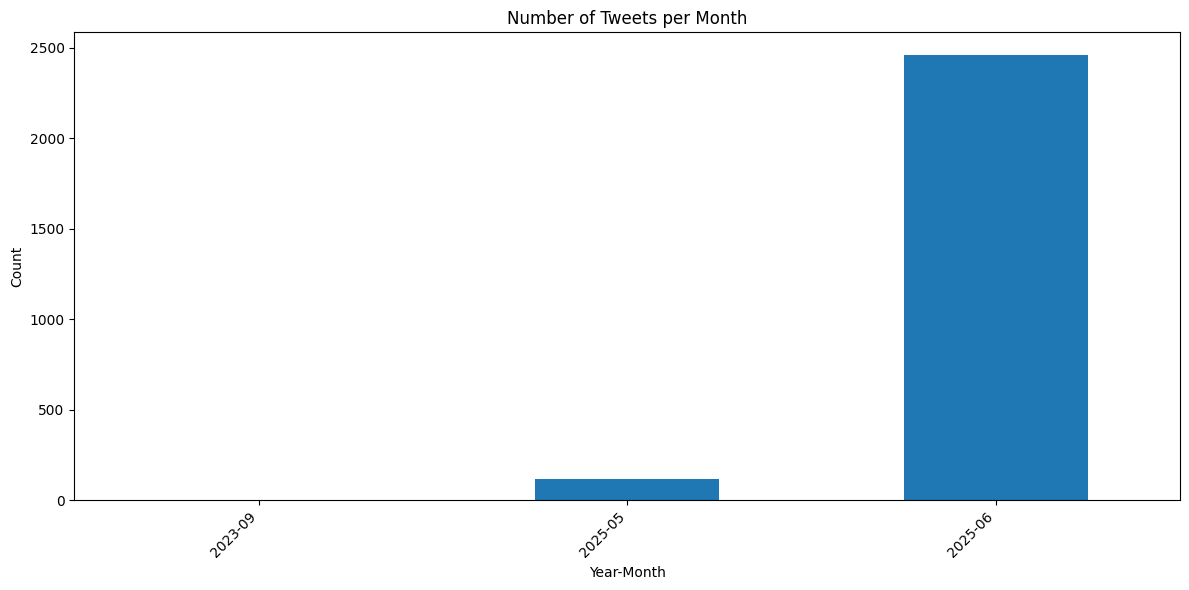

In [ ]:
x['Time'] = pd.to_datetime(x['Time'])
x['year_month'] = x['Time'].dt.to_period('M')

# Group by year and month and describe the 'text' column distribution
# Since 'text' is a string column, we can look at count, unique, top, and freq
grouped_by_month = x.groupby('year_month')['sentence']

# Print a description for each month
for name, group in grouped_by_month:
  print(f"Distribution for {name}:")
  print(group.describe())
  print("-" * 30)

# Alternatively, if you want to visualize the number of entries per month:
x['year_month'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Number of Tweets per Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


因為評論爬取規則是時間順序相關，故大部分來自6月

### 2. W2V

#### W2V模型設定

In [ ]:
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(
    docs, #過濾stopword的docs
    min_count=30, #忽略詞頻<30的詞
    window=2,   #前後兩個詞作為上下文
    vector_size=128,
    sample=0.005, #減少高頻詞的影響機率
    alpha=0.001,
    min_alpha=0.0005,
    negative=0,
    workers=cores-1,
    seed=8787,
    sg=1,#Skip‑gram
    epochs=30,
    hs=1 #hierarchical softmax
)

128高維度向量降維，投影並觀察到2D/3D圖，同時分群3D圖

為探討同一主題下的資料細微差異，我們使用t‑SNE方法，同一群內的微小差別拉得更開、更容易分辨

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def reduceDim(mat, method='PCA', dim=2, perplexity=20, learning_rate=400):
    if method == 'PCA':
        reducer = PCA(n_components=dim, random_state=0)
    elif method == 'TSNE':
        reducer = TSNE(n_components=dim, perplexity=perplexity, learning_rate=learning_rate, random_state=0)
    else:
        raise ValueError("method must be 'PCA' or 'TSNE'")
    return reducer.fit_transform(mat)

#### 2D圖

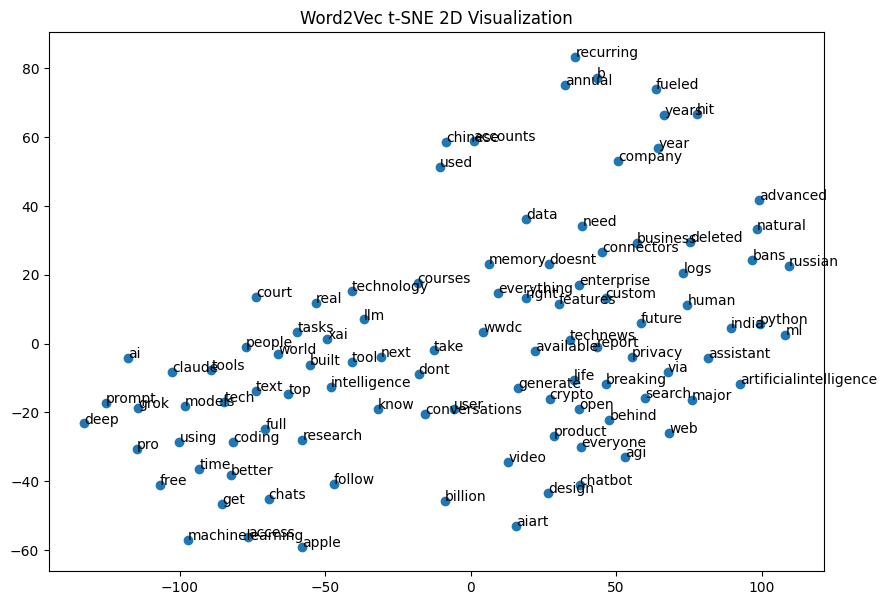

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

words = list(w2v_model.wv.index_to_key)
sample_words = np.random.choice(words, 100, replace=False)


vectors = np.array([w2v_model.wv[word] for word in sample_words])
reduced = reduceDim(vectors, method='TSNE', dim=2)# t-SNE:非線性降維，比照原空間相似分布，同義字距離近，不相似的則遠

# 繪製 2D 分布
plt.figure(figsize=(10, 7))
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, word in enumerate(sample_words):
    plt.text(reduced[i, 0], reduced[i, 1], word)
plt.title("Word2Vec t-SNE 2D Visualization")
plt.show()

#### 3D圖

In [ ]:
from sklearn.cluster import KMeans

vectors_3d = reduceDim(vectors, method='TSNE', dim=3)
kmeans = KMeans(n_clusters=3, random_state=0).fit(vectors_3d)
labels = kmeans.labels_

fig = px.scatter_3d(
    x=vectors_3d[:, 0],
    y=vectors_3d[:, 1],
    z=vectors_3d[:, 2],
    color=labels.astype(str),
    text=sample_words,
    title="Word2Vec + KMeans 3D Topic Clustering"
)
fig.show()

找出Kmeans分群中每個群集最接近其中心的top10字

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd

# 隨機取樣 100 個詞
words = list(w2v_model.wv.index_to_key)
sample_words = np.random.choice(words, 100, replace=False)

# 抽取向量
vectors = np.array([w2v_model.wv[word] for word in sample_words])

# 降成 3 維
tsne = TSNE(n_components=3, random_state=0, perplexity=25, learning_rate=400)
vectors_3d = tsne.fit_transform(vectors)

# KMeans 分群（3 群）
n_clusters = 3
kmeans_model = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors_3d)
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

# 建立 DataFrame
df = pd.DataFrame(vectors_3d, columns=["x", "y", "z"])
df["word"] = sample_words
df["cluster"] = labels

# 每群選出 Top 10 距離群中心最近的字
top_words_per_cluster = {}

for cluster_id in range(n_clusters):
    cluster_data = df[df["cluster"] == cluster_id]
    cluster_vectors = cluster_data[["x", "y", "z"]].values
    cluster_words = cluster_data["word"].values

    center = centers[cluster_id].reshape(1, -1)
    _, distances = pairwise_distances_argmin_min(cluster_vectors, center)

    top_indices = np.argsort(distances)[:10]
    top_words = cluster_words[top_indices]
    top_words_per_cluster[cluster_id] = top_words.tolist()

# 顯示結果
for cluster_id, words in top_words_per_cluster.items():
    print(f"\n📌 Cluster {cluster_id} Top 10 Words:")
    print(", ".join(words))





📌 Cluster 0 Top 10 Words:
features, students, sama, doesnt, hits, make, language, groups, enterprise, life

📌 Cluster 1 Top 10 Words:
deepseek, models, chats, conversations, memory, free, world, research, machinelearning, everything

📌 Cluster 2 Top 10 Words:
llm, generation, aiart, gpto, learn, start, build, tasks, major, reasoning


### 3. 主題模型

主題模型我們使用了LDA與BertTopic，因為最初使用BertTopic的時候，盡管很大限度的去除了停用字，但仍然有過多的主題(大於100)，這是因為資料集本身的特性影響，社群評論常常涵蓋不同面向的內容，而BertTopic會將這些微小的差異分開。因此我們用LDA作為我們選擇主題數量的輔助工具，計算出最佳的主題數量，並將BertTopic的HDBSCAN改為K-means，並設定分群數量。



#### LDA

In [ ]:
# 計算 bigrams.
# 針對docs建立一個 bigram 模型，找出出現次數大於20次的bigram
bigram = Phrases(docs, min_count=5)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # 將Token (bigram) 加入到docs裡面
            docs[idx].append(token)

In [ ]:
# 建立 docs 的 dictionary物件
dictionary = Dictionary(docs)
print(dictionary)

# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words
corpus = [dictionary.doc2bow(doc) for doc in docs]

Dictionary<10738 unique tokens: ['deepseek', 'exam', 'frontierindia', 'futurechina', 'hired']...>


##### 找出最佳主題數

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 16)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # 根據不同topic_num訓練LDA模型
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5
        )

    loss = model.log_perplexity(corpus)
    # 計算Perplexity和PMI值
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # 將結果儲存起來
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

花費時間: 89.57005310058594 sec


In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,6074.823943,-0.172401
1,3,6445.524579,-0.039366
2,4,6761.327772,-0.047810
3,5,7106.608778,-0.170606
4,6,7346.879153,-0.120370
5,7,7509.471750,-0.119130
6,8,7571.626479,-0.113564
7,9,7822.358899,-0.166504
8,10,7866.523446,-0.214802
9,11,7908.649214,-0.163796


<Axes: xlabel='topic_num'>

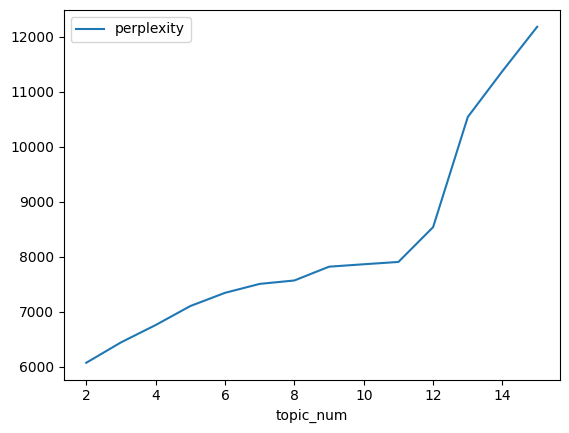

In [ ]:
result.plot.line(x='topic_num', y='perplexity')#以perplexity來看，主題數為2較好

<Axes: xlabel='topic_num'>

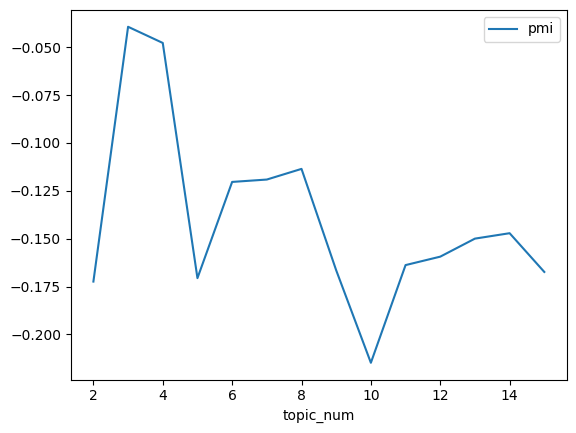

In [ ]:
result.plot.line(x='topic_num', y='pmi')#以pmi來看，主題數為3最好

從上面的結果來看，最佳主題數應該設定在2-5，最後我們選擇了3個主題數(方便後續的分析，而且pmi值也最高)

##### 視覺化LDA結果

In [ ]:
# 主題數 = 3 的模型
model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 1500,
    passes=10
    )

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.041925 -0.137266       1        1  37.199641
1     -0.154823  0.036389       2        1  32.553028
0      0.112897  0.100877       3        1  30.247332, topic_info=        Term        Freq       Total Category  logprob  loglift
72   revenue  185.000000  185.000000  Default  30.0000  30.0000
217  billion  144.000000  144.000000  Default  29.0000  29.0000
56         b  126.000000  126.000000  Default  28.0000  28.0000
860    voice  152.000000  152.000000  Default  27.0000  27.0000
215   annual  110.000000  110.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
209     free   31.684271   66.738418   Topic3  -5.9957   0.4508
470     logs   25.371044   33.337526   Topic3  -6.2179   0.9227
61       gpt   32.101285   89.875696   Topic3  -5.9826   0.1662
790   altman   26.092794   40.601879   Topic3  -6.1899   0.7536
266      api   25.521022   61.858582   Topic3  -6.2120   0.3104

[187 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
252       1  0.546193      access
252       2  0.264821      access
252       3  0.198616      access
233       1  0.880009    accounts
233       3  0.116815    accounts
...     ...       ...         ...
76        1  0.077061       years
76        2  0.909325       years
76        3  0.015412       years
822       3  0.970265        york
823       3  0.960026  york_times

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [ ]:
model.print_topics()

[(0,
  '0.022*"ai" + 0.011*"voice" + 0.007*"court" + 0.006*"mode" + 0.005*"users" + 0.005*"deleted" + 0.005*"advanced" + 0.005*"data" + 0.004*"using" + 0.003*"conversations"'),
 (1,
  '0.020*"ai" + 0.013*"revenue" + 0.010*"billion" + 0.009*"b" + 0.008*"annual" + 0.007*"recurring" + 0.005*"users" + 0.005*"hits" + 0.005*"annual_recurring" + 0.005*"growth"'),
 (2,
  '0.028*"ai" + 0.007*"accounts" + 0.006*"used" + 0.006*"chinese" + 0.005*"russian" + 0.005*"groups" + 0.005*"model" + 0.004*"bans" + 0.004*"using" + 0.004*"bans_accounts"')]

LDA產生的關鍵字並不會用於後續的LLM推論，但我們還是可以根據主題模型產生的關鍵字先大概推敲一下該主題的內容，輔助我們命名主題


*   主題1: 關鍵字的主題比較分散，有點難看出主要的內容，大概是跟AI的使用有相關
*   主題2: 出現revenue billion annual，跟這次OpenAI公布周年收益相關
*   主題3: 跟OpenAI的安全隱私問題相關




LDA Topic Distribution:
Topic 2: 966 documents
Topic 1: 842 documents
Topic 0: 775 documents


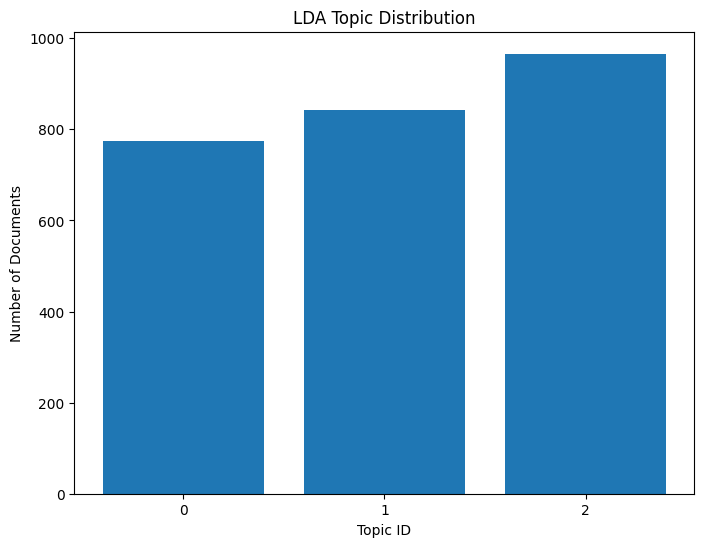

In [ ]:
# 比較lda model各個群集的資料量

import matplotlib.pyplot as plt
# Calculate the number of documents in each topic for the LDA model
topic_counts = defaultdict(int)
for doc_bow in corpus:
    # Get the topic distribution for the document
    doc_topics = model.get_document_topics(doc_bow)
    # Find the dominant topic for the document
    if doc_topics:
        dominant_topic = max(doc_topics, key=lambda item: item[1])[0]
        topic_counts[dominant_topic] += 1

print("\nLDA Topic Distribution:")
for topic_id, count in topic_counts.items():
    print(f"Topic {topic_id}: {count} documents")

# Visualize the topic distribution
plt.figure(figsize=(8, 6))
plt.bar(topic_counts.keys(), topic_counts.values())
plt.xlabel('Topic ID')
plt.ylabel('Number of Documents')
plt.title('LDA Topic Distribution')
plt.xticks(list(topic_counts.keys()))
plt.show()


#### BertTopic

##### 模型設定
BertTopic的模型設定中，我們使用了K-means作為分群方法並將k值設定為3，bert模型使用的是Allen Institute for AI 所開發的專門針對學術論文語料訓練的BERT

In [ ]:
docs = x['sentence'].tolist()

# 定義不同 layer 所要使用的模型與方法
cluster_model = KMeans(n_clusters=3)
embedding_model = "allenai-specter" # Embeddings layer
# hdbscan_model = HDBSCAN() # Clustering layer
vectorizer_model = CountVectorizer()

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=cluster_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)

##### Top 10關鍵字


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,932,0_ai_voice_image_mode,"[ai, voice, image, mode, prompt, using, advanc...",[supercharged voice mode subscribers sound nat...
1,1,893,1_ai_models_google_model,"[ai, models, google, model, research, agents, ...",[ai engineering specialization intro ai engine...
2,2,758,2_ai_revenue_billion_annual,"[ai, revenue, billion, annual, recurring, acco...",[top news post cnbc hits billion annual recurr...


In [ ]:
topic_model.get_topic(0)

[('ai', 0.09121061956676686),
 ('revenue', 0.02825932507194652),
 ('google', 0.024045931861142112),
 ('billion', 0.023286875248675613),
 ('models', 0.021810099221774033),
 ('model', 0.018757001710163933),
 ('users', 0.018756165874724073),
 ('research', 0.018626516634367127),
 ('gpt', 0.018287768724768224),
 ('annual', 0.017644035411325795)]

In [ ]:
topic_model.get_topic(1)

[('ai', 0.06954171345401014),
 ('voice', 0.053403961713208624),
 ('image', 0.03407671912070658),
 ('mode', 0.030462318925160124),
 ('prompt', 0.0303114613724958),
 ('advanced', 0.02329471447218127),
 ('aiart', 0.022360089612456568),
 ('using', 0.02064153648332146),
 ('grok', 0.018995565444402514),
 ('prompts', 0.016544871775774357)]

In [ ]:
topic_model.get_topic(2)

[('accounts', 0.10321944328708628),
 ('court', 0.10271462987800696),
 ('chinese', 0.09159158843148912),
 ('russian', 0.08006906097688422),
 ('deleted', 0.07819936357942411),
 ('privacy', 0.06387736240445145),
 ('bans', 0.06327398336333766),
 ('used', 0.06104520990737059),
 ('groups', 0.059943773712635665),
 ('chats', 0.05426674776413805)]

In [ ]:
words = topic_model.get_topic_info()

topic_word = words['Representation'].tolist()

topic_word

[['ai',
  'revenue',
  'google',
  'billion',
  'models',
  'model',
  'users',
  'research',
  'gpt',
  'annual'],
 ['ai',
  'voice',
  'image',
  'mode',
  'prompt',
  'advanced',
  'aiart',
  'using',
  'grok',
  'prompts'],
 ['accounts',
  'court',
  'chinese',
  'russian',
  'deleted',
  'privacy',
  'bans',
  'used',
  'groups',
  'chats']]

這邊我們可以看到，相較於LDA，BertTopic分出來的主題關鍵字更能畫分主題，原因也來自於BertTopic相較於LDA更能處理評論這種長度較短的句子。跟LDA相比，在安全隱私與商業收益的主題基本相同，另外一個主題包含了voice、image、prompt等關鍵字，為AI應用相關。

##### 視覺化顯示主題-詞彙分佈

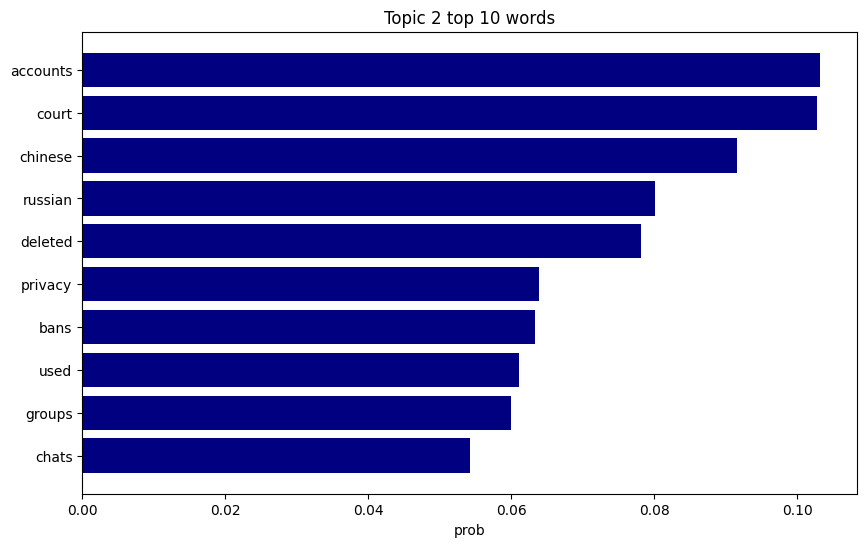

In [ ]:
# 視覺化顯示主題-詞彙分佈
topic_n = 2
data = topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('prob')
plt.title(f'Topic {topic_n} top 10 words')
plt.gca().invert_yaxis()
plt.show()

### 4. LLM主題推論
這個部分主要做了兩件事情，一個是透過將BertTopic產生的關鍵字交給LLM做主題推論，作為我們確認需要探討的主題命名的增強依據，結合LLM推論主題、BertTopic結果、基本文字分析結果，我們最終確立了3個主題，分別為AI Commercialization & Competition、AI Regulation & Privacy、AI Creativity & Applications。第二件事情是用LLM將評論分類到各自屬於主題內。

載入ollama，這邊使用的模型是gemma3:4b-it-qat

In [ ]:
# Step 1: Install Linux packages.
!apt-get install pciutils lshw
# Step 2: Install the Colab extension: colab-xterm
## Project Github Repo: https://github.com/InfuseAI/colab-xterm

!pip install -q colab-xterm
%load_ext colabxterm
# Step 3: Install ollama
## Project Github Repo: https://github.com/ollama/ollama

!curl https://ollama.ai/install.sh | sh
# Step 6: Launching Xterm.
## Notice: When xterm is successfully started, you need to run the ollama server and keep it running
## 若前一格安裝在此格出現的終端機中輸入指令: ollama serve
%xterm height=300

!ollama pull gemma3:4b-it-qat

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
lshw is already the newest version (02.19.git.2021.06.19.996aaad9c7-2build1).
pciutils is already the newest version (1:3.7.0-6).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
The colabxterm extension is already loaded. To reload it, use:
  %reload_ext colabxterm
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13281    0 13281    0     0  48144      0 --:--:-- --:--:-- --:--:-- 48119
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now avail

Launching Xterm...

<IPython.core.display.Javascript object>

Error: ollama server not responding - could not connect to ollama server, run 'ollama serve' to start it


In [ ]:
!ollama serve

time=2025-06-14T09:20:11.821Z level=INFO source=routes.go:1234 msg="server config" env="map[CUDA_VISIBLE_DEVICES: GPU_DEVICE_ORDINAL: HIP_VISIBLE_DEVICES: HSA_OVERRIDE_GFX_VERSION: HTTPS_PROXY: HTTP_PROXY: NO_PROXY: OLLAMA_CONTEXT_LENGTH:4096 OLLAMA_DEBUG:INFO OLLAMA_FLASH_ATTENTION:false OLLAMA_GPU_OVERHEAD:0 OLLAMA_HOST:http://127.0.0.1:11434 OLLAMA_INTEL_GPU:false OLLAMA_KEEP_ALIVE:5m0s OLLAMA_KV_CACHE_TYPE: OLLAMA_LLM_LIBRARY: OLLAMA_LOAD_TIMEOUT:5m0s OLLAMA_MAX_LOADED_MODELS:0 OLLAMA_MAX_QUEUE:512 OLLAMA_MODELS:/root/.ollama/models OLLAMA_MULTIUSER_CACHE:false OLLAMA_NEW_ENGINE:false OLLAMA_NOHISTORY:false OLLAMA_NOPRUNE:false OLLAMA_NUM_PARALLEL:0 OLLAMA_ORIGINS:[http://localhost https://localhost http://localhost:* https://localhost:* http://127.0.0.1 https://127.0.0.1 http://127.0.0.1:* https://127.0.0.1:* http://0.0.0.0 https://0.0.0.0 http://0.0.0.0:* https://0.0.0.0:* app://* file://* tauri://* vscode-webview://* vscode-file://*] OLLAMA_SCHED_SPREAD:false ROCR_VISIBLE_DEVICE

In [ ]:
!ollama run gemma3:4b-it-qat "你好!"  #這行執行後啟動模型


你好！很高兴和你聊天。有什么我可以帮助你的吗？你想聊些什么呢？




In [ ]:
llm = OllamaLLM(model="gemma3:4b-it-qat", temperature=1.0)

llm主題解釋

In [ ]:
# 建立提示模板
template = """你是一個科技領域的專家，請幫我根據以下各分類的前10個關鍵字判斷出他們是甚麼類別。

並分析以下3個主題的關鍵詞，並為每個主題給出一個簡短的敘述。這些關鍵字都來自於推特上關於Openai跟Gpt的貼文，以下是個主題的關鍵字：

{question}

請用以下格式回答：
主題0: [類別名稱]
主題1: [類別名稱]
主題2: [類別名稱]

給出敘述的同時要找出相關案例"""

prompt = PromptTemplate.from_template(template)

# 建立 chain
sentiment_value_chain = (
    {"question": RunnablePassthrough()} | prompt | llm
)

# 準備主題數據
topics_data = """主題0: 'ai',
  'revenue',
  'google',
  'models',
  'use',
  'billion',
  'users',
  'model',
  'research',
  'tools'

主題1: 'ai',
  'voice',
  'image',
  'prompt',
  'mode',
  'advanced',
  'grok',
  'aiart',
  'using',
  'im'

主題2: 'accounts',
  'court',
  'chinese',
  'order',
  'russian',
  'deleted',
  'used',
  'bans',
  'privacy',
  'groups'
"""

# 執行分類
result = sentiment_value_chain.invoke(topics_data)
print(result)



好的，我來根據您提供的關鍵字分析各主題的類別，並提供敘述和相關案例：

主題0: **AI 商業與經濟**
 
敘述： 此主題圍繞著人工智能技術的商業化，涵蓋了相關公司的收入、市場規模、競爭格局，以及AI模型的商業應用和投資。關鍵字“revenue”、“billion”、“users”、“Google”等表明了對AI技術產業經濟影響的關注。
 
相關案例：OpenAI 的商業模式以及其與 Google 的競爭關係一直是熱門話題。近年來，AI 領域的投資持續增長，許多企業都在積極探索如何將 AI 技術納入其商業戰略中。例如，Google 的 Gemini 模型和 OpenAI 的 GPT-4 模型，都直接影響了市場格局和投資方向。

主題1: **AI 應用與創意**
 
敘述： 此主題主要探討 AI 在創意應用領域的發展，例如 AI 生成圖像（"aiart"、"im"）、語音助手 ("voice") 以及指令（"prompt”）對AI互動的影響。 "Grok" 代表了OpenAI近期推出的大型模型，與其生成能力相關。 
 
相關案例：OpenAI 的 DALL-E 和 Midjourney 等 AI 圖像生成模型，迅速風靡全球，展示了 AI 在創造性領域的潛力。此外，OpenAI 的 ChatGPT 也展現了在創意寫作、程式碼生成等方面的能力。最近，OpenAI 的 “Grok” 模型著重於強化AI模型對大文本的理解能力，使其生成回复的質量大幅提升。

主題2: **AI 監管與爭議**
 
敘述： 此主題圍繞著 AI 技術的監管、倫理問題以及相關的法律爭議。關鍵字“accounts”、“court”、“deleted”、“bans”、“privacy”、“groups”、“chinese”、“russian”等，指向了OpenAI關於用戶賬戶、數據隱私、以及涉及不同國家法律的行為，尤其是與中國和俄羅國家相關的內容。 
 
相關案例：OpenAI 在 2023 年底面臨俄羅斯和中國政府的壓力，其服務受到限制。OpenAI 隨後刪除了部分用戶數據，並與中國政府就數據洩露問題進行談判。最近，美國法院下令OpenAI 停止某些服務的運行，以解決與數據隱私和安全性相關的訴訟。 這些事件突顯了 AI 技術在跨境應用時面臨的監管挑戰。

希望這些分析對您有幫助！



In [ ]:
class X_Comm(BaseModel):
    類別: str = Field(..., description="判斷評論屬於哪個類別", enum=["AI Commercialization & Competition", "AI Creativity & Applications", "AI Regulation & Privacy"])

new_parser = JsonOutputParser(pydantic_object=X_Comm)

# 透過 get_format_instructions() 可以看到如何告訴 LLM 生成我們想要的格式的一些指令
new_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"類別": {"title": "類別", "description": "判斷評論屬於哪個類別", "enum": ["AI Commercialization & Competition", "AI Creativity & Applications", "AI Regulation & Privacy"], "type": "string"}}, "required": ["類別"]}\n```'

In [ ]:
# Set up a parser + inject instructions into the prompt template.
news_parser = JsonOutputParser(pydantic_object=X_Comm)\

news_template = """你是一位優秀的AI領域專家，你將會看到推特上的貼文，請判斷出該貼文講述的類別，以下是你需要分類的類別：
1.AI Commercialization & Competition
2.AI Creativity & Applications
3.AI Regulation & Privacy

{format_instructions}
請使用英文回答。
除了 JSON 內容外，不要回答任何其他內容

現在請幫我抓取以下句子的資訊：
句子：{query}
抓取結果：
"""

news_prompt = PromptTemplate(
    template=news_template,
    # template="Answer the user query.\n{format_instructions}\nDon't output any other explanation\n{query}\n",
    input_variables=["query"],
    # 將 format_instructions 也輸入到 prompt templete 中
    partial_variables={"format_instructions": news_parser.get_format_instructions()},
)

chain = news_prompt | llm
chain.get_graph().print_ascii()

ImportError: Install grandalf to draw graphs: `pip install grandalf`.

In [ ]:
# 從 json 字串中抓取答案
def extract_answer_from_string(string_):
    string_ = string_.replace("\n", "")
    string_ = string_.replace("json", "")
    string_ = string_.replace("    ", "")
    string_ = string_.replace("```", "")
    try:
        # 可以成功轉換
        dict_result = json.loads(string_)
    except:
        print(string_)
        return string_
    return dict_result

# 從 dict 抓取情緒
def get_class(row):
    news_class = None
    if isinstance(row, dict):
        if ("類別" in row.keys()):
            news_class = row['類別']
    return news_class

因為推論過程需要花費較多時間，這邊就先將原本的資料貼上類別標籤後存下來

In [ ]:
x['LLM'] = x.apply(lambda x: extract_answer_from_string(chain.invoke({"query": x['Content']})), axis=1)

x.to_csv('D:\社媒\SMA_2025S-main\SMA_final\LLM_class.csv',index=False, encoding="utf-8-sig")

### 5. 官方文件RAG

載入PDF

In [ ]:
!pip install pypdf
!pip install langchain_community langchain_chroma grandalf langchain_huggingface pypdf sentence-transformers
!pip install langchain_chroma
!pip install grandalf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.2 MB/s eta 0:00:00


In [ ]:
loader = PyPDFLoader("raw_data/a-practical-guide-to-building-agents.pdf") #這是 OpenAI 官方發布的技術指南，目標是教你如何構建 Agent 系統
pages = loader.load()
pages
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=200,    #希望不要有資訊遺失
    length_function=len,
    is_separator_regex=False,
)
texts = text_splitter.split_documents(pages)
texts[:1]

[Document(metadata={'producer': 'pdf-lib (https://github.com/Hopding/pdf-lib)', 'creator': 'pdf-lib (https://github.com/Hopding/pdf-lib)', 'creationdate': '2025-04-07T14:20:51+00:00', 'moddate': '2025-04-07T14:20:54+00:00', 'source': 'raw_data/a-practical-guide-to-building-agents.pdf', 'total_pages': 34, 'page': 0, 'page_label': '1'}, page_content='A  p r a c t i c a l  \u2028\ng u i d e  t o  \u2028\nb u i l d i n g  a g e n t s')]

將文檔轉換為 embedding
存入 vectorDB

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "all-MiniLM-L6-v2"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}

embedding_function = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
vectorstore = Chroma.from_documents(documents=texts, embedding=embedding_function)

retriever = vectorstore.as_retriever()

測試找尋相關文檔(去看是否真能檢索到vectorDB)

In [ ]:
# query it
query = "Selecting your models"
docs = vectorstore.similarity_search(query)

# print results
print(docs[0].page_content)

if  the y  still achie v e accep table r esults.  This w a y ,  y ou don ’t pr ema tur ely  limit the agen t’ s abilities,  
and y ou can diagnose wher e smaller  models succeed or  f ail.
I n  s u m m a r y ,  t h e  p r i n c i p l e s  f o r  c h o o s i n g  a  m o d e l  a r e  s i m p l e :  
01 Se t up e v als t o establish a perf ormance baseline
02 F ocus on mee ting y our  accur ac y  tar ge t with the best models a v ailable
03 Op timiz e f or  cost and la t enc y  b y  r eplacing lar ger  models with smaller  ones  
wher e possible
Y ou can find a compr ehensiv e guide t o selec ting OpenAI models her e .
8 A  p r a c t i c a l  g u i d e  t o  b u i l d i n g  a g e n t s


定義 RAG prompt 與 chain

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_prompt_template = """<start_of_turn>user
"角色": "OpenAI 技術說明文件助理",
"任務說明":
你是一位熟悉 OpenAI 發布之《A Practical Guide to Building Agents》的技術助理。
你會根據該文件內容協助工程師或研究人員回答關於 Agent 架構設計、工具、模型等相關問題。

[文件內容]
{context}
[文件內容結束]

[回答規則]
- 僅根據上述文件中的內容回答，不猜測或杜撰文件中未明確指出的資訊。
- 若問題無法從文件中得到解答，請回覆：「我很抱歉，我無法根據文件提供這個問題的答案。」
- 回答需簡潔、明確，並保持在 150 字以內。
- 所有回答請以 [答案]: 開頭。
[回答規則結束]

請回答以下問題：
問題: ({question})
<end_of_turn>
<start_of_turn>model
[答案]:
"""

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

rag_prompt = PromptTemplate.from_template(rag_prompt_template)

# 組合 RAG Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
)

# 可視化確認 chain 結構
rag_chain.get_graph().print_ascii()

            +---------------------------------+         
            | Parallel<context,question>Input |         
            +---------------------------------+         
                    **               ***                
                 ***                    **              
               **                         ***           
+----------------------+                     **         
| VectorStoreRetriever |                      *         
+----------------------+                      *         
            *                                 *         
            *                                 *         
            *                                 *         
    +-------------+                    +-------------+  
    | format_docs |                    | Passthrough |  
    +-------------+*                   +-------------+  
                    **               ***                
                      ***         ***                   
                         **    

開始問問題(以下問題的回答的確遵照文件內容)

In [ ]:
rag_chain.invoke("What are the three components of an OpenAI agent?")

'An OpenAI agent consists of three core components: a model (the LLM powering reasoning), tools (external functions or APIs), and instructions (guidelines and guardrails defining agent behavior). The document highlights these elements as foundational to agent design.'

In [ ]:
rag_chain.invoke("What's the principles for choosing a model")

'[答案]:\n原則如下：1. 設置基準以確定性能；2. 集中於實現所需的準確度，並使用可用的最佳模型；3. 針對成本和延遲進行優化，並在可能的情況下用較小的模型替換較大的模型。'

In [ ]:
rag_chain.invoke("What are two primary triggers typically warrant human intervention.")

'[答案]: 兩項主要觸發機制通常需要人工介入：\n\n1.  **超出失敗閾值：** 如果代理人多次嘗試完成任務而無法成功（例如，無法理解客戶意圖），則需要將其轉交給人工。\n2.  **高風險操作：** 涉及敏感、不可逆或影響範圍大的操作，應觸發人工審閱。例如，取消用戶訂單、 authorizing 大額資金或執行付款。\n'

### 6. 情緒分析

#### 資料前處理

讀取之前存下來的資料

In [3]:
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SMA_finalProject/final_sma/raw_data/LLM_class.csv")
test = test.dropna(subset = ['sentence'])
test.head()

,index,Time,Content,sentence,LLM
0,0,2025-06-01T14:13:27.000Z,USA : OpenAI is leading the future.\nChina ...,usa leading futurechina deepseek next frontier...,{'新聞類別': 'AI Commercialization & Competition'}
1,1,2025-06-10T02:14:19.000Z,Here's another way ChatGPT is being used to fu...,heres another way used fuel disinformation phi...,{'新聞類別': 'AI Commercialization & Competition'}
2,2,2025-06-08T16:53:08.000Z,It's been 24 hours since the OpenAI changed ...,hours since changed ai video world sorahere mi...,{'新聞類別': 'AI Commercialization & Competition'}
3,3,2025-06-10T02:10:51.000Z,JUST IN: OpenAI drops the price of o3 by 80%...,drops price developers activating posts talkin...,{'新聞類別': 'AI Commercialization & Competition'}
4,4,2025-06-09T18:06:12.000Z,OpenAI hits $10B ARR just 2.5 years after the...,hits b arr years launch gpt theinformation rep...,{'新聞類別': 'AI Commercialization & Competition'}


In [4]:
# 停用字清單
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
custom_stopwords = [
    'chatgpt', 'openai', 'new', 'us', 'like',
    'whats', 'actually', 'look', 'want', 'best', 'last',
    'since', 'latest', 'thats', 'made', 'also',
    'ive', 'ask', 'cant', 'think',
    'including', 'good', 'said', 'asked', 'every', 'without', 'write',
    'back', 'going', 'heres', 'day', 'different',
    'first', 'see', 'use',
    'says', 'got', 'today',
    'could', 'vs', 'im', 'help',
    'week', 'way', 'still', 'read',
    'even', 'less', 'two', 'one', 'order'
]
additional_stopwords = [
    'may', 'run', 'team',
    'already', 'isnt', 'youre', 'plan', 'building', 'created',
    'many', 'say', 'much', 'making'
]
stop_words.extend(custom_stopwords + additional_stopwords)

# 移除停用字
test['sentence'] = test['sentence'].apply(
    lambda s: ' '.join([word for word in s.split() if word not in stop_words])
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import ast

def get_class(row):
    try:
        if isinstance(row, str):
            row = ast.literal_eval(row)  # 安全轉為 dict
        if isinstance(row, dict):
            return row.get('新聞類別', None)
    except:
        return None

In [6]:
test['class'] = test.apply(lambda x: get_class(x['LLM']), axis=1)
test.head()

,index,Time,Content,sentence,LLM,class
0,0,2025-06-01T14:13:27.000Z,USA : OpenAI is leading the future.\nChina ...,usa leading futurechina deepseek next frontier...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition
1,1,2025-06-10T02:14:19.000Z,Here's another way ChatGPT is being used to fu...,another used fuel disinformation philippines m...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition
2,2,2025-06-08T16:53:08.000Z,It's been 24 hours since the OpenAI changed ...,hours changed ai video world sorahere mindblow...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition
3,3,2025-06-10T02:10:51.000Z,JUST IN: OpenAI drops the price of o3 by 80%...,drops price developers activating posts talkin...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition
4,4,2025-06-09T18:06:12.000Z,OpenAI hits $10B ARR just 2.5 years after the...,hits b arr years launch gpt theinformation rep...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition


#### 使用bert對評論貼上情緒標籤

In [7]:
test['class'].value_counts()

,count
class,
AI Commercialization & Competition,1981
AI Creativity & Applications,443
AI Regulation & Privacy,155


載入專門用於社群語意分析的bert，並將模型任務設定為情緒分析

In [8]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
model = pipeline('sentiment-analysis', model=model_name)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [9]:
# 建立一個新的 dataframe 來儲存結果
results_x = pd.DataFrame(columns=['sentence', 'label', 'score'])
results_x['sentence'] = test['Content']

# 定義一個函數來進行情緒分析
def analyze_sentiment(sentence):
    result = model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# 使用 apply 函數來進行情緒分析
test[['label', 'score']] = test['sentence'].apply(analyze_sentiment)

# 輸出結果

In [10]:
#將對應的標籤更改為負面、中立、正面
mapping_dict = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive'
}

test['label'] = test['label'].map(mapping_dict)

test['label'].value_counts()

,count
label,
Neutral,1770
Positive,470
Negative,340


In [11]:
# 算出每類別情緒總和(sentiment_count)

sentiment_count = pd.DataFrame(test.groupby(['class', 'label']).size()).reset_index()

mask = (sentiment_count['label'] == "Positive") | (sentiment_count['label'] == "Negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: 'size'})
sentiment_count.head(10)

,class,label,size
0,AI Commercialization & Competition,Negative,265
2,AI Commercialization & Competition,Positive,343
3,AI Creativity & Applications,Negative,19
5,AI Creativity & Applications,Positive,127
6,AI Regulation & Privacy,Negative,56


找出正面情緒的評論

In [12]:
test_p = test[test['label'] == 'Positive']
test_p

,index,Time,Content,sentence,LLM,class,label,score
2,2,2025-06-08T16:53:08.000Z,It's been 24 hours since the OpenAI changed ...,hours changed ai video world sorahere mindblow...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Positive,0.629785
5,5,2025-06-09T04:44:44.000Z,AI trends in 2025 are mind-blowing! Advanced ...,ai trends mindblowing advanced reasoning model...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Positive,0.546552
15,15,2025-06-09T18:39:04.000Z,OpenAI hits $10 billion in annual recurring r...,hits billion annual recurring revenue fueled g...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Positive,0.640446
17,17,2025-06-09T20:45:36.000Z,Welcome to a simpler way to integrate #AI . ...,welcome simpler integrate ai digitalocean serv...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Positive,0.700332
25,25,2025-06-09T23:12:58.000Z,My two coins from this Aider LLM Leaderboards ...,coins aider llm leaderboards result geminiapp ...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Positive,0.842008
...,...,...,...,...,...,...,...,...
2570,2682,2025-06-10T07:17:27.000Z,. @OpenAI hits $10 billion in annual recurri...,hits billion annual recurring revenue fueled g...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Positive,0.579571
2575,2687,2025-06-10T07:36:07.000Z,"According to sources familiar with the matter,...",according sources familiar matter outperformed...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Positive,0.610093
2576,2688,2025-06-10T07:35:13.000Z,“Just in: @OpenAI (or whatever the latest) r...,whatever releases multimodal model understands...,{'新聞類別': 'AI Creativity & Applications'},AI Creativity & Applications,Positive,0.595100
2578,2690,2025-06-10T07:37:19.000Z,OpenAI pushed an update to ChatGPT 's Advanc...,pushed update advanced voicethe release makes ...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Positive,0.607126


找出負面情緒的評論

In [13]:
test_n = test[test['label'] == 'Negative']
test_n

,index,Time,Content,sentence,LLM,class,label,score
1,1,2025-06-10T02:14:19.000Z,Here's another way ChatGPT is being used to fu...,another used fuel disinformation philippines m...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Negative,0.697283
20,20,2025-06-05T19:00:31.000Z,We are already seeing AI agents like OpenAI '...,seeing ai agents codex production number agent...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Negative,0.677533
24,24,2025-06-10T02:55:01.000Z,it has been 16 months since OpenAI announced...,months announced sora havent seen real updates...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Negative,0.481870
44,44,2025-06-07T18:39:38.000Z,tf is this?? lmfao @OpenAI,tf lmfao,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Negative,0.470536
53,53,2025-06-02T00:04:47.000Z,"OpenAI was ordered to shut down…\n\nInstead, ...",ordered shut downinstead moment ai stops liste...,{'新聞類別': 'AI Regulation & Privacy'},AI Regulation & Privacy,Negative,0.909875
...,...,...,...,...,...,...,...,...
2546,2658,2025-06-08T23:28:05.000Z,OpenAI is on a STREAK for breaking ChatGPT ...,streak breaking interface daily,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Negative,0.523433
2560,2672,2025-06-10T07:03:47.000Z,"Artificial Intelligence, Biggest Curse on Huma...",artificial intelligence biggest curse humanity...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Negative,0.662945
2561,2673,2025-06-10T07:17:04.000Z,I hope @OpenAI doesn't do anything with the ...,hope doesnt anything answer better interface b...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Negative,0.704230
2568,2680,2025-06-10T07:19:43.000Z,"Unpopular opinion but CHATGPT is dumb AF, wh...",unpopular opinion dumb af whoever thinking tak...,{'新聞類別': 'AI Commercialization & Competition'},AI Commercialization & Competition,Negative,0.891250


#### 視覺化各類別正負面評論數量

In [14]:
pos = sentiment_count[sentiment_count['label']=='Positive']
neg = sentiment_count[sentiment_count['label']=='Negative']

In [15]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 150

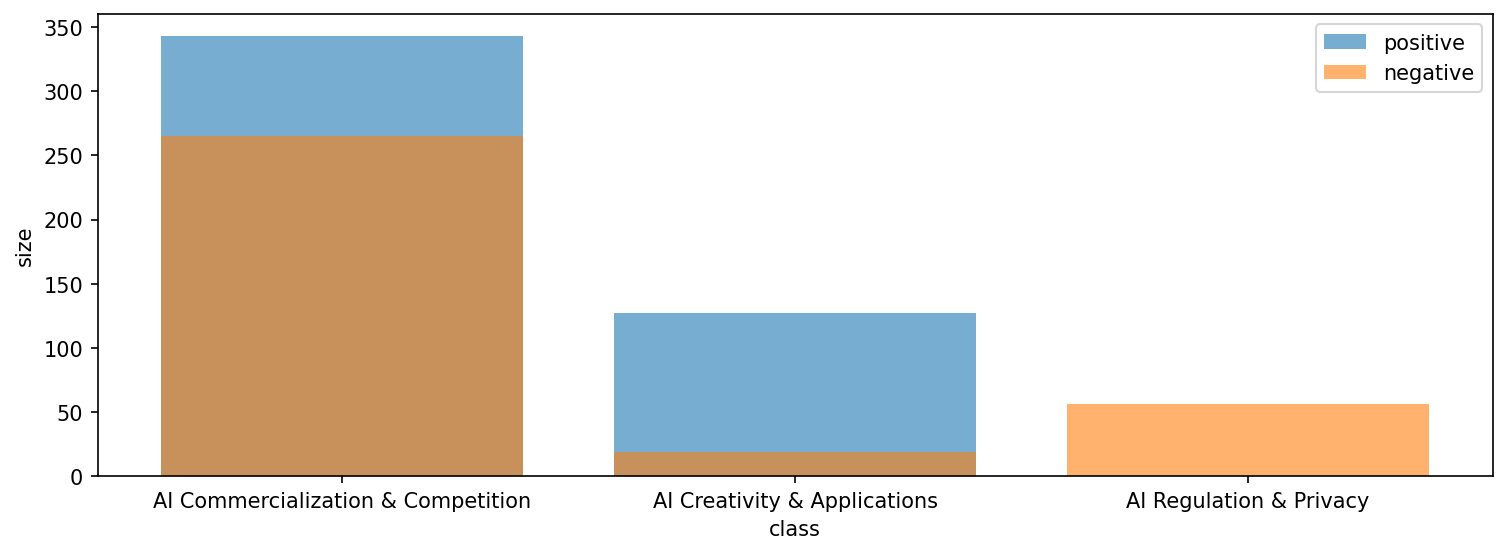

In [16]:
# you can find other color pattern here: https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ["tab:blue",  "tab:orange"]
fig, ax = plt.subplots()

ax.bar(pos['class'],
       pos['size'],
       color = colors[0],
       alpha = 0.6,
       align='center')
ax.bar(neg['class'],
       neg['size'],
       color = colors[1],
       alpha = 0.6,
       align='center')
plt.xlabel('class')
plt.ylabel('size')

ax.legend(['positive','negative'], loc ='upper right')
plt.show()

這邊可以看到，在去除情緒中立的貼文後，CA類別的正向比例較高;CC跟RP類的負面貼文比例較多，所以後面會透過貼文內容看OpenAI有哪些令人滿意和抱怨的部分

#### 計算正負面評論的關鍵字

In [17]:
from collections import Counter

def get_top_words_by_sentiment(df, label_column='label', text_column='sentence', top_n=20):
    sentiment_keywords = {}

    for label in df[label_column].unique():
        subset = df[df[label_column] == label]
        words = []
        for sentence in subset[text_column]:
            tokens = sentence.split()
            words.extend(tokens)
        word_freq = Counter(words).most_common(top_n)
        sentiment_keywords[label] = word_freq

    return sentiment_keywords


正向評論關鍵字

In [18]:
pos_words_rp = get_top_words_by_sentiment(test_p[test_p['class']=='AI Regulation & Privacy'])
pos_words_ca = get_top_words_by_sentiment(test_p[test_p['class']=='AI Creativity & Applications'])
pos_words_cc = get_top_words_by_sentiment(test_p[test_p['class']=='AI Commercialization & Competition'])

負向評論關鍵字

In [19]:
neg_words_rp = get_top_words_by_sentiment(test_n[test_n['class']=='AI Regulation & Privacy'])
neg_words_ca = get_top_words_by_sentiment(test_n[test_n['class']=='AI Creativity & Applications'])
neg_words_cc = get_top_words_by_sentiment(test_n[test_n['class']=='AI Commercialization & Competition'])

In [20]:
# 印出每種情緒的前 20 個關鍵字
def print_top(keywords):
    for label, words in keywords.items():
        print(f"\nTop words for {label}:")
        for word, count in words:
            print(f"{word}: {count}")

In [21]:
print_top(pos_words_ca)


Top words for Positive:
ai: 63
voice: 36
mode: 20
prompt: 16
advanced: 15
image: 12
natural: 12
using: 11
aiart: 11
tools: 10
create: 10
gpto: 10
dalle: 10
style: 10
users: 9
update: 9
human: 9
video: 9
tool: 8
prompts: 8


#### 繪製文字雲

##### CA類正負評論文字雲

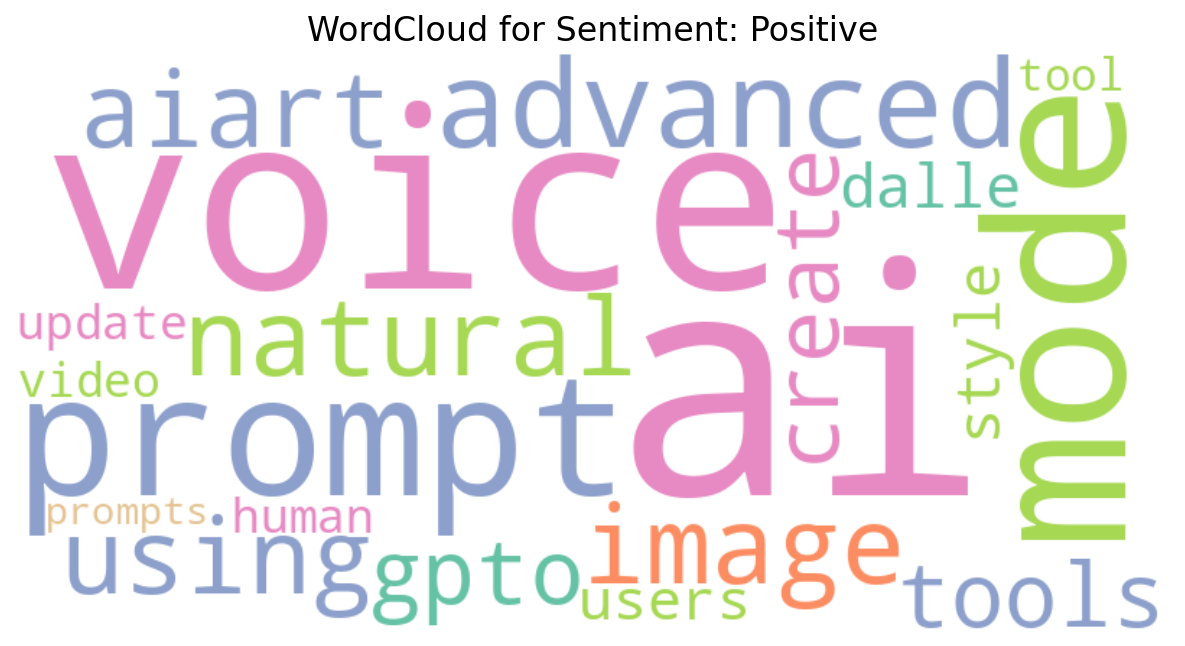

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds_by_sentiment(keywords_dict):
    for sentiment, word_freq in keywords_dict.items():
        # 將關鍵字轉為 dict 格式 {word: frequency}
        freq_dict = dict(word_freq)

        # 建立文字雲物件
        wc = WordCloud(
            width=800, height=400,
            background_color='white',
            colormap='Set2'
        ).generate_from_frequencies(freq_dict)

        # 顯示文字雲
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for Sentiment: {sentiment}", fontsize=16)
        plt.show()

# 使用剛剛的 keywords 結果
plot_wordclouds_by_sentiment(pos_words_ca)

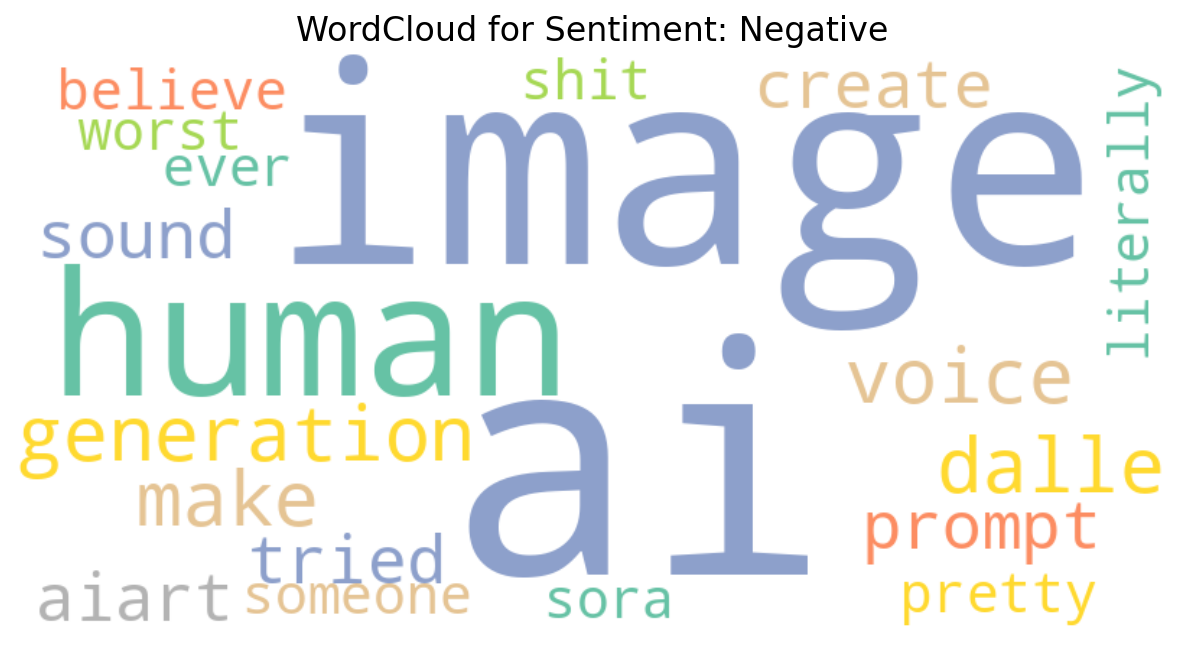

In [23]:
plot_wordclouds_by_sentiment(neg_words_ca)

##### CC類正負評論文字雲

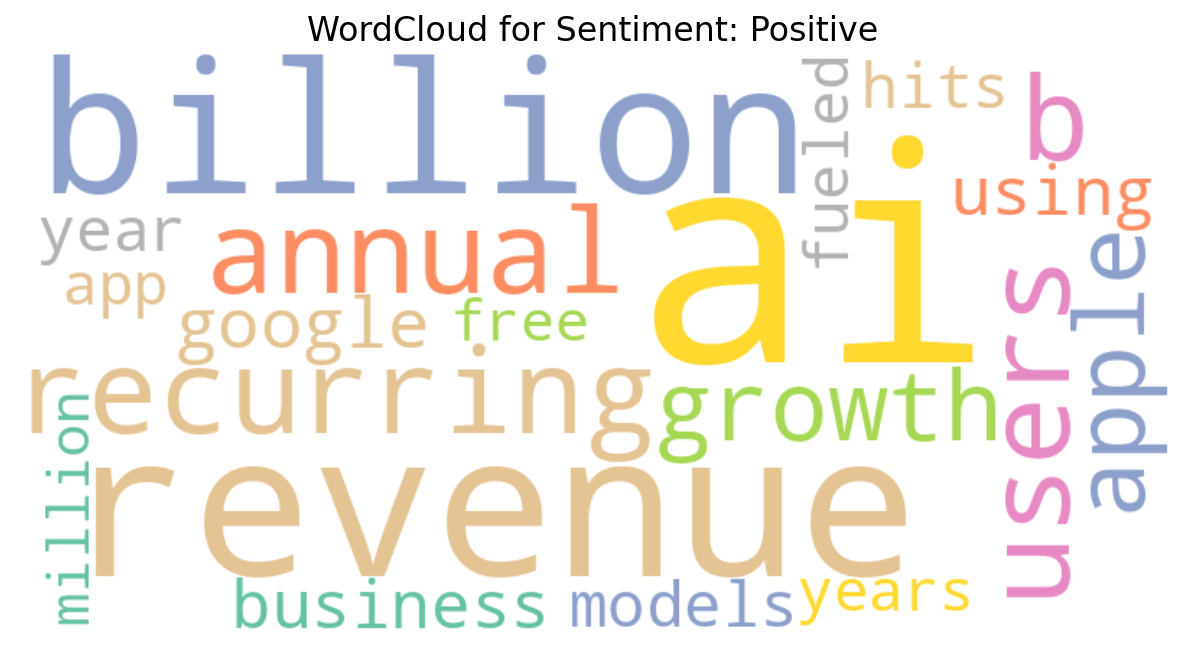

In [24]:
plot_wordclouds_by_sentiment(pos_words_cc)

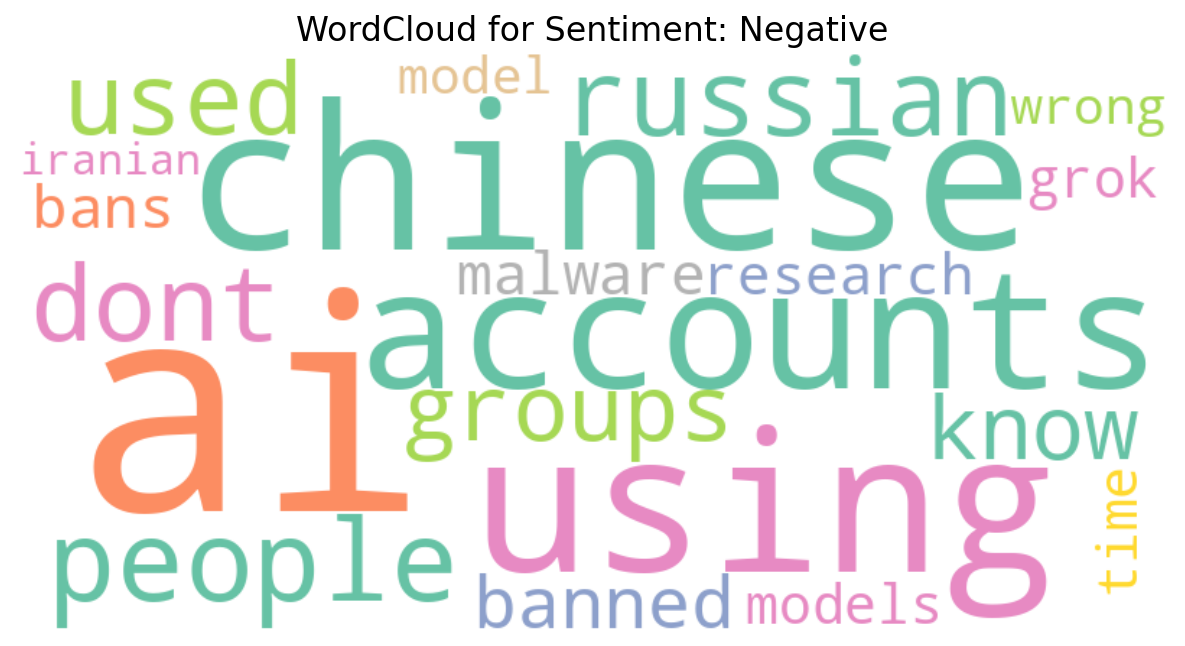

In [25]:
plot_wordclouds_by_sentiment(neg_words_cc)

##### RP類負面評論文字雲

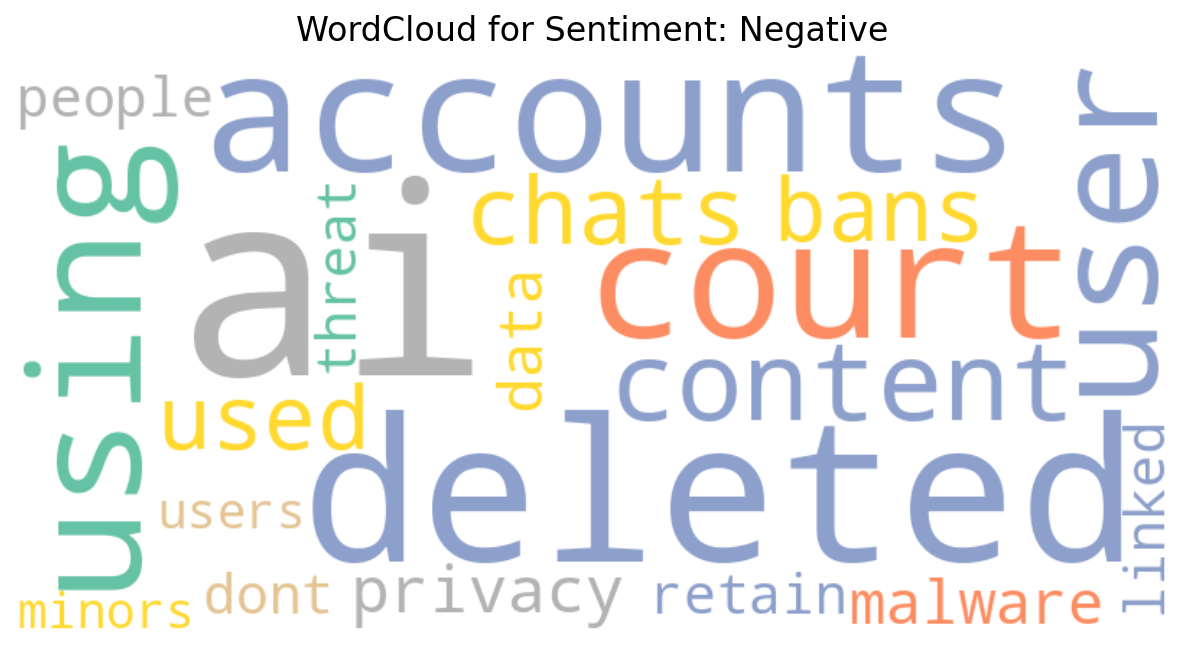

In [26]:
plot_wordclouds_by_sentiment(neg_words_rp)

#### 根據關鍵字查詢評論內容

In [27]:
print(test['class'].unique())

['AI Commercialization & Competition' 'AI Regulation & Privacy'
 'AI Creativity & Applications' None]


In [28]:
def check_comm(sentimentdict, class_name, keyword):
    mask = (sentimentdict['class'] == f"{class_name}") & (
    sentimentdict['sentence'].str.contains(f'{keyword}'))

    df_ = sentimentdict.loc[mask, ["Content", "sentence"]]

    for text in df_['Content']:
        print(text)
        print('-' * 50)

##### CA類正面評論，關鍵字為image

In [29]:
check_comm(test_p, 'AI Creativity & Applications', 'image')

10 Most Searched AI Topics Last Week

Generative AI Tools Keep Getting Better
People are really curious about the latest generative AI tools like  #ChatGPT  and Claude.  #OpenAI   new image generator, which lets users create art from text, has been a big hit. Folks are exploring how
--------------------------------------------------
OpenAI ’s newly released 4o Image Generation is not just powerful — it is incredibly useful for architects.
--------------------------------------------------
4. DALL-E 3

DALL-E 3, developed by  OpenAI , is an image generation tool that creates high-quality visuals based on textual prompts, offering features like inpainting and style adaptation. https://
--------------------------------------------------
5. DALL-E 3

DALL-E 3, developed by  OpenAI , is an image generation tool that creates high-quality visuals based on textual prompts, offering features like inpainting and style adaptation. https://
--------------------------------------------------
Possib

許多用戶對 OpenAI 最新推出的 GPT-4o 與 DALL·E 3 表現出高度滿意。DALL·E 3 能夠根據文字提示生成高品質視覺圖像的工具，並具備如圖像修補（inpainting）與風格轉換等進階功能。使用者認為其生成效果細膩、風格豐富。GPT-4o 所展現的多模態整合能力也讓用戶印象深刻。其與動畫工具（如 Kling AI、Hailuo AI）以及聲音平台（如 ElevenLabs）的整合，使得圖像、動畫與聲音得以同步創作，用戶得以產出完整的 AI 藝術作品。有使用者指出其圖像理解與細節捕捉能力甚至超越其他平台如 Midjourney 與 LeonardoAI。OpenAI 與 Apple 的合作亦引起關注。雙方推出的「Image Playground」與「Genmoji」功能，讓使用者能在注重隱私與安全的環境下進行個人化圖像創作。

##### CC類正面評論，關鍵字是revenue

In [30]:
check_comm(test_p, 'AI Commercialization & Competition','revenue')

OpenAI  hits $10 billion in annual recurring revenue fueled by ChatGPT growth #AIRevolution   #OpenAI   #ChatGPT   #TechMilestone   #Aiversity
--------------------------------------------------
NEWS:  OpenAI ’s annual recurring revenue has almost doubled to $10 billion from $5.5 last year 

>expects to be profitable in 2029 when revenue hits $125 billion
--------------------------------------------------
OpenAI  owner of ChatGPT has just hit $10B in recurring revenue for the first time ever.

Just last year this recurring revenue was under $4B. Insane growth!
--------------------------------------------------
OpenAI  Achieves $10 Billion In Yearly Recurring Revenue Driven By ChatGPT Expansion
--------------------------------------------------
OpenAI’s ongoing revenue momentum is supported by a rapidly expanding user base and diversified offerings. The company now counts 500 million weekly active users as of March 2025. #OpenAI   #ChatGPT  

Read more here https:// g/openais-annualised-

OpenAI 於 2025年年經常性營收（Annual Recurring Revenue, ARR）突破 100 億美元，不到三年的時間內從 ChatGPT 推出初期的數十億迅速增長，其中 2024 年底為 55 億美元、2023 年僅約為 37 億左右，代表年度成長率高達 80% 以上，成長速度相當快速。營收快速成長的主要動力來源是 ChatGPT。根據多則報導指出，ChatGPT App 與企業商用方案（如 API、ChatGPT Team、ChatGPT Enterprise）是主要營收來源，而 API 的占比已逐漸小於 ChatGPT 本身。OpenAI 的商業版圖正從單一模型平台，擴展為完整的 AI 產品生態系。但OpenAI 仍處於虧損狀態。根據報導，2024 年的營運虧損約為 50 億美元，但隨著規模經濟發揮（operating leverage），公司財務狀況正逐步改善。未來目標更加宏大，OpenAI 預計 在 2029 年實現 1250 億美元營收，屆時達到獲利轉折點。

##### CC類的負面評論，關鍵字為accounts

In [31]:
check_comm(test_n, 'AI Commercialization & Competition','accounts')

OpenAI  banned  ChatGPT  accounts linked to Russian and Chinese hackers using AI to build stealthy malware and automate attacks.

They refined malware code, hid it in fake gaming tools, stole browser data, evading detection.

Read details here ↓
--------------------------------------------------
OpenAI bans Philippine accounts using ChatGPT for a pro-Marcos comment campaign. Political spam with AI? They’re not letting it slide.  #AI   #ChatGPT   #Philippines
--------------------------------------------------
#OpenAI  has revealed that it banned a set of  #ChatGPT  accounts that were likely operated by Russian-speaking threat actors and two Chinese nation-state hacking groups to assist with malware. #2025  #Infosec   #BT https:// -bans-chatgpt-accounts-used-by.html?utm_campaign=meetedgar&utm_medium=social&utm_source=meetedgar.com … http:// meetedgar&utm_medium=social&utm_source=meetedgar.com …
--------------------------------------------------
#OpenAI  bans  #ChatGPT  accounts linked to

OpenAI 採取行動，封鎖多組濫用 ChatGPT 的帳號，這些帳號與多個國家支持的駭客組織有關，包括來自俄羅斯、中國、伊朗、北韓及菲律賓的攻擊者，這些攻擊手段包括malware程式碼、自動化生成攻擊內容、涉及求職詐騙與選舉干預等行為。這次封鎖顯示出了生成式 AI 的潛在風險，也反映出 OpenAI 在平台治理與資安管理上仍需要加強警備，也說明了 AI 在國際政治與網路安全中正扮演日益關鍵的角色。

##### RP類的負面評論，關鍵字為deleted與privacy

In [33]:
check_comm(test_n, 'AI Regulation & Privacy','deleted')

ChatGPT  is storing your deleted conversations...
And might be doing that indefinitely.

It doesn't even matter whether you're a Pro, Plus user or you bought it for your entire team.
--------------------------------------------------
@OpenAI  is fighting a court order from The NYT requiring it to retain all ChatGPT user chats, even deleted ones, under user infringement concerns.

Altman called it “inappropriate” and proposed an “AI privilege” similar to doctor-patient confidentiality. #SCALER   #OpenAI   #AI
--------------------------------------------------
The court order forcing  OpenAI  to hoard every  ChatGPT  interaction—including deleted chats—is peak bureaucratic overreach. This isn’t about protecting copyrights; it’s about weaponizing the legal system to create a surveillance dragnet under the guise of litigation. The NYT’s
--------------------------------------------------
YOUR DELETED CHATS WERE NOT REALLY DELETED:  OpenAI  Faces User Backlash Over Indefinite  ChatGPT  Log R

In [34]:
check_comm(test_n, 'AI Regulation & Privacy','privacy')

ngl i've grown quite paranoid of  chatgpt  since  openai  is collecting all our conversations, even the ones that we delete.

so i tried to run an ai modal locally (for privacy and it's free). but this shit is slow asf.

gotta hoard some ram chips and high vram gpus before 2027.
--------------------------------------------------
A court just ordered  OpenAI  to STOP deleting any user chats. Is your DELETED  ChatGPT  history GONE forever? Think again. A judge says NO.  #fyp   #foryou   #ecomhackers   #news   #OpenAI   #ChatGPT   #TechNews   #LegalTech   #AICommunity   #DataPrivacy
--------------------------------------------------
OpenAI  Is Ordered to Save Every  ChatGPT  Chat - Even those deleted

  THANKS to NY Times #theyhateyou   #privacy ---

Brazilian Comedian Leo Lins Sentenced to 8 Yrs

  Telling the wrong joke now carries more jail time than most white-collar crime. #theyhateyou   #overthrowtyrants
--------------------------------------------------
#Crypto   #AI   #Web3 OpenAI

將兩個關鍵字找出的貼文結合來看，內容大致都指向了今年6月美國聯邦法案的的一項裁決，就是OpenAI 被要求保留所有 ChatGPT 使用者對話紀錄，包括已刪除的聊天紀錄。此命令源自The New York Times針對潛在版權侵權所提出的訴訟要求，旨在保留完整對話資料作為法律依據，無論使用者是否曾手動刪除紀錄。使用者對此嚴重侵犯隱私的結果表達了不滿，引發了使用者對AI的信任危機，也突顯了AI 與法律、倫理之間的矛盾跟衝突。隨著法律壓力與企業商業模式交互影響，用戶越來越關心自己在使用 AI 工具時，實際能掌握多少數據控制權，但對此是呈現擔憂的態度。

### 結論


1. 專案總結<br>
透過抓取X上2000多則關於OpenAI 與 Chatgpt的貼文後，我們首先對資料進行了前處理，用W2V模型將字詞向量化之後畫出了2D圖與3D圖。主題模型部分，我們先用LDA找出了最適合的主題數之後，使用BertTopic產生了3個主題的關鍵字。在產生關鍵字後，我們將關鍵字交給LLM產生主題類別後並對每一則貼文推論分類標籤。同時我們還建置了一個簡單的RAG，目的是為了幫助使用者快速理解模型的相關知識。最後，我們對貼好情緒標籤與類別標籤的貼文做了情緒分析，並根據我們想要的類別、情緒、關鍵字分析。
<br>

2. 分析結果總結<br>
* AI強大的多模態生成能力在使用者之間受到強烈的好評，生成的內容有較高的真實性、個人化是使用者非常在意的地方。
* OpenAI的營收成長快速，盡管仍處於虧損階段，但是將在不久的未來實現營利。OpenAI的營利模式也從API本身轉變成圍繞著Chatgpt打造的生態系。
* 在治理AI方面，OpenAI仍遇到許多挑戰，可能是來自敵對的惡意攻擊、隱私與安全疑慮、政治與法律約束等。

<br>


3. 給出希望向AI轉型企業的建議<br>
* 生成內容須自由與個人化<br>
若企業希望自己的AI產品是面向多模態創意生成方面，那麼生成的內容就要高度符合使用者需求(如兒童畫風、建築概念圖、故事視覺化)，而生成也要滿足即時生成、修改與風格遷移的效率與便利性，並提供使用者自行生成內容的空間與工具。
* 打造圍繞AI的生態系<br>
從OpenAI的商業模式中我們能看到，AI本身已經不再是一間公司最大的賣點，圍繞著AI打造生態系才是目前的生存之道。建議企業建構可模組化的AI技術整合，例如支援 API 接入、多模態模型部署等，供客戶打造專屬的AI工具。或效仿OpenAI與Apple的合作，將AI工具與其他系統結合，強化使用者體驗與價值。
* 強化資料治理與隱私透明<br>
隱私與資料安全一直是AI繞不開的話題，建議企業公開透明資料使用與存取政策，保障使用者刪除權與存取知情權，X就提到過，任何人都能免費使用Grok，但免費的前提是使用者的回覆資料都會被免費收集。另外，對於比較敏感與重要資料的儲存，企業可以透過部屬本地端的AI模型提高隱私自主權。






